In [1]:
using Base: @kwdef
using Parameters: @unpack

In [2]:
# kwdefを使うと初期値の設定をstruct内に入れられる(pythonのコンストラクタっぽく使える)

@kwdef struct LIFParameter{FT}
    tref::FT = 2 #不応期(ms)
    tc_m::FT = 10 # 膜時定数(ms)
    vrest::FT = -60 # 静止膜電位(mV)
    vreset::FT = -65 # リセット電位(mV)
    vthr::FT = -40 # 閾膜電位(mV)
    vpeak::FT = 30 # ピーク電位(mV)
end

@kwdef mutable struct LIF{FT}
    param::LIFParameter = LIFParameter{FT}()
    N::UInt32 # ニューロンの数
    v::Vector{FT} = fill(-65.0, N) # 膜電位(mV)
    v_::Vector{FT} = fill(-65.0, N) # 発火電位も記録する変数
    fire::Vector{Bool} = zeros(Bool, N) # 発火
    tlast::Vector{FT} = zeros(N) # 最後の発火時刻(ms)
    tcount::FT = 0 # 時間カウント
end 

In [3]:
#ifelse(条件式, 条件が一致した場合の処理, 条件が一致しなかった場合の処理)
function update!(variable::LIF, param::LIFParameter, I::Vector, dt)
    @unpack N, v, v_, fire, tlast, tcount = variable
    @unpack tref, tc_m, vrest, vreset, vthr, vpeak = param
    
    @inbounds @simd for i = 1:N
        #v[i] += dt * ((vrest - v[i] + I[i]) / tc_m) # 不応期がない場合
        v[i] += dt * ((dt*tcount) > (tlast[i] + tref)) * ((vrest - v[i] + I[i]) / tc_m)
    end
    @inbounds @simd for i = i:N
        fire[i] = v[i] >= vthr
        v_[i] = ifelse(fire[i], vpeak, v[i])
        v[i] = ifelse(fire[i], vreset, v[i])
        tlast[i] = ifelse(fire[i], dt*tcount, tlast[i]) # 発火時刻の更新
    end
end

update! (generic function with 1 method)

In [4]:
# 遅延時間をバラバラにしたい場合は、for loopが必須になるので注意

@kwdef mutable struct Delay_Connection{FT}
    N::UInt32 # ニューロンの数
    delay::Float32
    dt::Float32
    nt_delay::UInt32 = round(Int64,delay/dt)
    state::Matrix{FT} = zeros(N, nt_delay)
    out = zeros(N)
end 

#ifelse(条件式, 条件が一致した場合の処理, 条件が一致しなかった場合の処理)
function Delay_Connection_call!(variable::Delay_Connection, x, dt)
    @unpack N,delay,dt,nt_delay,state,out = variable
    #out = zeros(N, 1) # mutableに置くと毎回初期化されてしまうので注意
    out = state[:, end]
    state[:, 2:end] = state[:, 1:end-1]　# 配列をずらす(pythonだとこっちの方がnp.rollより早いらしい)
    state[:, 1] = x
    return out
end

Delay_Connection_call! (generic function with 1 method)

In [10]:
T = 450 # ms
dt = 0.01f0 # ms
nt = UInt32(T/dt) # number of timesteps
N = 10 # ニューロンの数

# 入力刺激
t = Array{Float32}(1:nt)*dt
# .>のピリオドで要素ごとに比較している
I = repeat(25f0 * ((t .> 50) - (t .> 200)) + 50f0 * ((t .> 250) - (t .> 400)), 1, N)  # injection current

# 記録用
varr1 = zeros(Float32, nt, N)
varr2 = zeros(Float32, nt, N)

# modelの定義
neurons = LIF{Float32}(N=N)
delay_connection = Delay_Connection{Float64}(N=N, delay=10, dt=dt)

# simulation
i = 1;
@time for i = 1:nt
    update!(neurons, neurons.param, I[i, :], dt)
    neurons.tcount += 1
    varr1[i, :] = neurons.fire
    ret = Delay_Connection_call!(delay_connection, neurons.fire, dt)
    varr2[i, :] = ret
end

  1.114104 seconds (4.54 M allocations: 3.432 GiB, 8.68% gc time)


In [13]:
using Plots
p1 = plot(t, varr1[:, 1], color="black")
p2 = plot(t, varr2[:, 1], color="black")
p3 = plot(t, I[:, 1], color="black")
plot(p1, p2, p3,
    xlabel = ["" "" "Times (ms)"], 
    ylabel= ["Firing" "Firing" "Current"],
    layout = grid(3, 1, heights=[0.3, 0.3, 0.4]), legend=false, size=(600,300))

In [6]:
T = 1000 # ms
dt = 0.01f0 # ms
nt = UInt32(T/dt) # number of timesteps

N = 100 # ニューロンの数

# 入力刺激
mincurrent = 15
maxcurrent = 40
t = Array{Float32}(1:nt)*dt
I = Array{Float32}(range(mincurrent,maxcurrent,length=N)) # injection current

# modelの定義
neurons = LIF{Float32}(N=N)

# 記録用
firearr = zeros(Bool, nt, N)

# simulation
@time for i = 1:nt
    update!(neurons, neurons.param, I[:], dt)
    neurons.tcount += 1
    firearr[i, :] = neurons.fire
end

  2.857353 seconds (81.28 M allocations: 1.263 GiB, 4.56% gc time)


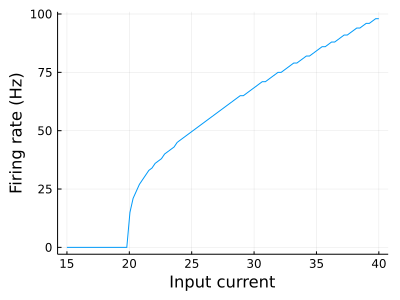

In [7]:
num_spikes = sum(firearr, dims=1)
rate = num_spikes/T*1e3

plot(I[:], rate[1, :],
    xlabel="Input current",
    ylabel="Firing rate (Hz)", legend=false, size=(400,300))

In [8]:
tc_m = 10 # 膜時定数 (ms)
tref = 2 # 不応期 (ms)

R = 1.0 #膜抵抗 
vrest = -60.0 # 静止膜電位 (mV) 
vthr = -40.0 # 閾値電位 (mV)
rate = zeros(N)

for i = 1:N
    z = R*I[i] / (R*I[i] + vrest - vthr)
    if z > 0
        rate[i] = 1 / (tref + tc_m * log(z)) * 1e3
    else
        rate[i] = 0
    end
end 

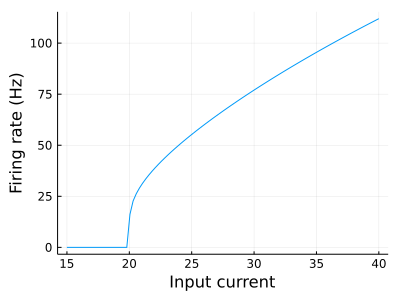

In [9]:
plot(I[:], rate[:],
    xlabel="Input current",
    ylabel="Firing rate (Hz)", legend=false, size=(400,300))